# Homework assignment

Your main assignment at this point is to train and evaluate a DQN or similar architecture on another game.

In general, you can pick any game (through course staff agreement), but by default we recommend one of these:
* seaquest
* ms_pacman
* kung_fu_master
* breakout
* alien (better than the the reference notebook) 

You can use classwork_solution notebook for reference, but know that it is __suboptimal in terms of training speed__, so you will be able to improve over it.

### Formal
A submission should contain 
* your code
* evaluation (total rewards from 20+ games in a row)
* some videos of your DQN performance
* An ideal submission would also contain saved weights and a [binder](mybinder.org)-ready repository like this where one can load and run a pre-trained model.

Since we are using an altered version of OpenAI Gym atari (removing the known bug with flickering), submitting it directly to gym would be impossible until they change the standard environment. You can, however, pick an official environment (via gym.make) instead of modified one and fix the flickering issue on agent side.

### Tips

__Fix Qlearning loss explosion__(if you get NaNs):
 * Some games have rewards on a larger scale than others.
  * this causes mean squared error to explode
 * Donwscale or clip rewards when computing objective function
 * Alternatively, reduce learning rate or switch to a more robust optimization algorithm

__Stabilize training__:
 * More parallel agents
  * works with any method, but required more computation than experience replay
 * Experience replay (see solution)
  * works less efficiently with on-policy RL (SARSA, A2c)
 * Target networks
  * idea: take referece Q-values from an earlier network snapshot
  * `from agentnet.target_network import TargetNetwork`; rtfd.
 * Google some new algorithms

__Other learning algorithms__:
 * Most common algorithms already implemented in agentnet.learning.*
 * One can implement any other loss function using theano
 * Sarsa, K-step Qlearning and Advantage Actor Critic are on policy algorithms
  * they tend to have slower convergence if you use long experience replay buffer
 * Some learning functions have a space for known modiffications
  * e.g. qlearning supports Double Q-learning, bootstrap Q-learning and others

__Recurrent memory cells__:
 * Only make sense in partially observable environments.
 * Basically a DQN trained with BPTT.
 * Now SEQ_LENGTH starts to matter
 * See agentnet docs and examples for some use cases.
 
__Other__:
 * Avoid using SEQ_LENGTH=1: you need "next state" for most algorithms.
 * Qlearning objective MSE can and will raise and fall between iterations. The only thing that matters is average session reward.
 * General coding advice: only add more complexity when you're sure that current version works fine.
 * If docs didn't solve it, contact us for help.


In [34]:
def fprint(string):
    with open('results', 'a') as f:
        f.write(string + '\n')

In [35]:
fprint('xyu')

In [2]:
from __future__ import print_function 
import matplotlib.pyplot as plt
import numpy as np
from env import Atari
import lasagne
from lasagne.layers import InputLayer, DimshuffleLayer
from lasagne.layers import Conv2DLayer,Pool2DLayer,DenseLayer,batch_norm,dropout
from agentnet.agent import Agent
from pool import AtariGamePool
from agentnet.learning import qlearning
import theano
from IPython.display import HTML


%matplotlib inline
%env THEANO_FLAGS="floatX=float32"

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5105)


env: THEANO_FLAGS="floatX=float32"


In [3]:
#global params.

#game title. full list of games = http://yavar.naddaf.name/ale/list_of_current_games.html
GAME="breakout"

#game image will be resized from (210,160) to your image_size. 
#You may want a bigger image for your homework assignment IF you want a larger NN
IMAGE_W,IMAGE_H = IMAGE_SIZE =(105,80)

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 20
SEQ_LENGTH = 5

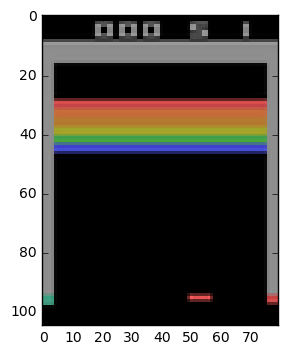

In [4]:
from env import Atari

#creating a game
atari = Atari(GAME,image_size=IMAGE_SIZE) 

action_names = np.array(atari.get_action_meanings())

obs = atari.step(0)[0]

plt.imshow(obs,interpolation='none')

In [5]:
action_names

array(['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE'], 
      dtype='|S9')

In [6]:
#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None, IMAGE_W, IMAGE_H, 3))

#reshape to [sample, color, x, y] to allow for convolutional layers to work correctly
observation_reshape = DimshuffleLayer(observation_layer, (0, 3, 1, 2))

In [7]:
from lasagne.layers import Conv2DLayer,Pool2DLayer,DenseLayer,batch_norm,dropout

conv0 = Conv2DLayer(observation_reshape, num_filters=32, filter_size=(8,8),stride=(4,4),name='conv0', nonlinearity=lasagne.nonlinearities.rectify)

conv1 = Conv2DLayer(batch_norm(conv0),num_filters=64,filter_size=(4,4),stride=(2,2),name='conv1', nonlinearity=lasagne.nonlinearities.rectify)

conv2 = Conv2DLayer(batch_norm(conv1), num_filters=64, filter_size=(3,3),stride=(1,1),name='conv2', nonlinearity=lasagne.nonlinearities.rectify)

dense0 = DenseLayer(batch_norm(conv2),
                    512, name='dense1',
                    nonlinearity = lasagne.nonlinearities.rectify,
                    W=lasagne.init.Orthogonal('relu'))

#please set this to your last layer for convenience
last_layer = dense0

In [8]:
#a layer that predicts Qvalues
qvalues_layer = DenseLayer(last_layer,
                   num_units = atari.action_space.n,
                   nonlinearity=lasagne.nonlinearities.linear,
                   name="q-evaluator layer")

#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer,name="e-greedy action picker")

action_layer.epsilon.set_value(np.float32(0.1))


In [9]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=qvalues_layer,
              action_layers=action_layer)

In [10]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0_bn.beta,
 conv0_bn.gamma,
 conv1.W,
 conv1_bn.beta,
 conv1_bn.gamma,
 conv2.W,
 conv2_bn.beta,
 conv2_bn.gamma,
 dense1.W,
 dense1.b,
 q-evaluator layer.W,
 q-evaluator layer.b]

In [11]:
from pool import AtariGamePool

pool = AtariGamePool(agent,GAME, N_AGENTS,image_size=IMAGE_SIZE,max_size=10000)

In [12]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


fprint(action_names[action_log][:2])
fprint(reward_log[:2])

[['RIGHT' 'RIGHT' 'RIGHT' 'RIGHT' 'RIGHT' 'RIGHT' 'RIGHTFIRE']
 ['RIGHT' 'RIGHT' 'RIGHT' 'RIGHT' 'RIGHT' 'RIGHT' 'FIRE']]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
CPU times: user 1.14 s, sys: 3.44 ms, total: 1.14 s
Wall time: 1.14 s


In [13]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(32,replace=True)

_,_,_,_,qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    optimize_experience_replay=True,
)

In [14]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#crop rewards to [-1,+1] to avoid explosion.
#import theano.tensor as T
#rewards = T.maximum(-1,T.minimum(rewards,1))

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2

elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions,
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [15]:
updates = lasagne.updates.rmsprop(loss, weights,learning_rate=0.00025, rho=0.95)

In [16]:
#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

In [18]:
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2016-10-29 07:07:42,855] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-29 07:07:42,856] Clearing 4 monitor files from previous run (because force=True was provided)
[2016-10-29 07:07:42,897] Starting new video recorder writing to /home/ubuntu/dqn_binder/records/openaigym.video.0.2447.video000000.mp4
[2016-10-29 07:08:01,106] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/dqn_binder/records')


Episode finished after 344 timesteps with reward=0.0


In [19]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {epoch_counter:untrained_reward}

In [20]:
def save_weights(epoch, ts):
    np.save('epoch_ts_time {}:{}:{}'.format(epoch, ts, datetime.now()), layers.get_all_params(last_layer)) 

In [ ]:
## #the loop may take eons to finish.
#consider interrupting early.
for i in xrange(1, 100):    
    #train
    pool.update(SEQ_LENGTH,append=True)
    
    for ts in range(25000):
        loss = train_step(i, ts)
        if ts % 1000 == 0:
            with open('results', 'a')
            fprint(loss)
        if True:#ts % 5000 == 0:
            save_weights(i, ts)
        
        
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/1000.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        fprint("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        

    ##record current learning progress and show learning curves
    if epoch_counter%10 ==0:
        rewards[epoch_counter] = pool.evaluate(record_video=False)
        rewards = T.maximum(-1,T.minimum(rewards,1))
        
        plt.title("random frames")
        for j in range(min((len(pool.games),6))):
            plt.subplot(2,3,j+1)
            plt.imshow(pool.games[j].get_observation())
        plt.show()

    
    epoch_counter  +=1

    
# Time to drink some coffee!

In [120]:
test = pool.evaluate(n_games=2, save_path="./records",record_video=True)

[2016-10-27 18:12:15,947] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-27 18:12:15,948] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-10-27 18:12:15,989] Starting new video recorder writing to /home/ubuntu/dqn_binder/records/openaigym.video.70.25674.video000000.mp4
[2016-10-27 18:12:20,803] Starting new video recorder writing to /home/ubuntu/dqn_binder/records/openaigym.video.70.25674.video000001.mp4


Episode finished after 426 timesteps with reward=3.0


[2016-10-27 18:12:25,685] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/dqn_binder/records')


Episode finished after 424 timesteps with reward=3.0


In [121]:
ls records

openaigym.episode_batch.70.25674.stats.json
openaigym.manifest.70.25674.manifest.json
openaigym.video.70.25674.video000000.meta.json
openaigym.video.70.25674.video000000.mp4
openaigym.video.70.25674.video000001.meta.json
openaigym.video.70.25674.video000001.mp4


In [88]:
import os

In [127]:
video_name = 'openaigym.video.70.25674.video000001.mp4'

In [130]:
from IPython.display import HTML

video_path=os.path.join('.', 'records', video_name)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


In [129]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=20,save_path="./records",record_video=True)
fprint("mean session score=%f.5"%rw)

[2016-10-27 18:13:44,259] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-27 18:13:44,260] Clearing 4 monitor files from previous run (because force=True was provided)
[2016-10-27 18:13:44,302] Starting new video recorder writing to /home/ubuntu/dqn_binder/records/openaigym.video.72.25674.video000000.mp4
[2016-10-27 18:13:49,244] Starting new video recorder writing to /home/ubuntu/dqn_binder/records/openaigym.video.72.25674.video000001.mp4


Episode finished after 424 timesteps with reward=3.0
Episode finished after 424 timesteps with reward=3.0


Exception gym.error.Error: Error('env has been garbage collected. To keep using a monitor, you must keep around a reference to the env object. (HINT: try assigning the env to a variable in your code.)',) in <bound method Atari.__del__ of <env.Atari object at 0x7f8c5f769190>> ignored
Exception gym.error.Error: Error('env has been garbage collected. To keep using a monitor, you must keep around a reference to the env object. (HINT: try assigning the env to a variable in your code.)',) in <bound method Monitor.__del__ of <gym.monitoring.monitor.Monitor object at 0x7f8c5f769f90>> ignored


KeyboardInterrupt: 

In [96]:
ls './records'

openaigym.episode_batch.57.25674.stats.json
openaigym.manifest.57.25674.manifest.json
openaigym.video.57.25674.video000000.meta.json
openaigym.video.57.25674.video000000.mp4
openaigym.video.57.25674.video000001.meta.json
openaigym.video.57.25674.video000001.mp4
openaigym.video.57.25674.video000008.meta.json
openaigym.video.57.25674.video000008.mp4


classwork.ipynb           homework assignment.ipynb
classwork_solution.ipynb  pool.py
Dockerfile                pool.pyc
dqn_slide.odp             README.md
dqn_slide.pdf             records/
env.py                    spaceinvaders_dqn_body_small.pcl
env.pyc
